In [1]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
#from tensorflow import set_random_seed
tf.random.set_seed(4)
from util import csv_to_dataset, history_points

Using TensorFlow backend.


In [2]:
f='mcd_intraday.csv'
# dataset

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset(f)

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)


# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


# evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape

(1694, 50, 5)
(189, 50, 5)
Train on 1524 samples, validate on 170 samples
Epoch 1/50
1524/1524 [==============================] - 2s 1ms/step - loss: 0.0203 - val_loss: 4.4022e-04
Epoch 2/50
1524/1524 [==============================] - 1s 772us/step - loss: 0.0027 - val_loss: 4.3316e-04
Epoch 3/50
1524/1524 [==============================] - 1s 778us/step - loss: 0.0023 - val_loss: 2.6640e-04
Epoch 4/50
1524/1524 [==============================] - 1s 829us/step - loss: 0.0019 - val_loss: 3.8166e-04
Epoch 5/50
1524/1524 [==============================] - 2s 1ms/step - loss: 0.0017 - val_loss: 1.9519e-04
Epoch 6/50
1524/1524 [==============================] - 1s 887us/step - loss: 0.0017 - val_loss: 1.6260e-04
Epoch 7/50
1524/1524 [==============================] - 1s 782us/step - loss: 0.0014 - val_loss: 1.6580e-04
Epoch 8/50
1524/1524 [==============================] - 1s 773us/step - loss: 0.0013 - val_loss: 2.0129e-04
Epoch 9/50
1524/1524 [==============================] - 1s 818us/s

In [3]:
unscaled_y_test.shape

(189, 1)

In [4]:
unscaled_y_test

array([[162.29  ],
       [162.245 ],
       [162.205 ],
       [162.1979],
       [162.16  ],
       [162.16  ],
       [162.18  ],
       [162.159 ],
       [162.2   ],
       [162.1859],
       [162.2   ],
       [162.2353],
       [162.23  ],
       [162.23  ],
       [162.19  ],
       [162.19  ],
       [162.07  ],
       [162.03  ],
       [162.0695],
       [162.22  ],
       [162.1   ],
       [162.08  ],
       [162.015 ],
       [162.04  ],
       [162.05  ],
       [162.07  ],
       [162.055 ],
       [162.095 ],
       [162.08  ],
       [161.971 ],
       [161.8311],
       [161.98  ],
       [161.9242],
       [162.005 ],
       [162.19  ],
       [162.2978],
       [162.275 ],
       [162.29  ],
       [162.305 ],
       [162.3643],
       [162.4225],
       [162.49  ],
       [162.46  ],
       [162.45  ],
       [162.41  ],
       [162.425 ],
       [162.45  ],
       [162.41  ],
       [162.41  ],
       [162.38  ],
       [162.4   ],
       [162.35  ],
       [162.

In [5]:
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

2.414883061943937


In [6]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(f'technical_model.h5')

<Figure size 2200x1500 with 1 Axes>

In [7]:
y=unscaled_y_test[start:end]
x=y_test_predicted[start:end]

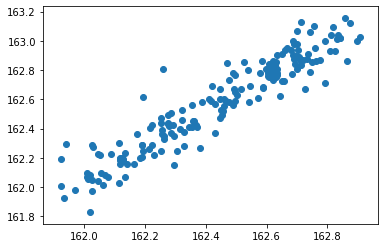

In [8]:
plt.scatter(x,y)
plt.show()

In [9]:
from sklearn.metrics import r2_score
r2_score(x,y)

0.5344400182764213

In [10]:
len(y)

188

In [11]:
y_normaliser

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
unscaled_y_test

array([[162.29  ],
       [162.245 ],
       [162.205 ],
       [162.1979],
       [162.16  ],
       [162.16  ],
       [162.18  ],
       [162.159 ],
       [162.2   ],
       [162.1859],
       [162.2   ],
       [162.2353],
       [162.23  ],
       [162.23  ],
       [162.19  ],
       [162.19  ],
       [162.07  ],
       [162.03  ],
       [162.0695],
       [162.22  ],
       [162.1   ],
       [162.08  ],
       [162.015 ],
       [162.04  ],
       [162.05  ],
       [162.07  ],
       [162.055 ],
       [162.095 ],
       [162.08  ],
       [161.971 ],
       [161.8311],
       [161.98  ],
       [161.9242],
       [162.005 ],
       [162.19  ],
       [162.2978],
       [162.275 ],
       [162.29  ],
       [162.305 ],
       [162.3643],
       [162.4225],
       [162.49  ],
       [162.46  ],
       [162.45  ],
       [162.41  ],
       [162.425 ],
       [162.45  ],
       [162.41  ],
       [162.41  ],
       [162.38  ],
       [162.4   ],
       [162.35  ],
       [162.

In [13]:
y_test

array([[0.20639835],
       [0.19711042],
       [0.18885449],
       [0.18738906],
       [0.17956656],
       [0.17956656],
       [0.18369453],
       [0.17936017],
       [0.1878225 ],
       [0.18491228],
       [0.1878225 ],
       [0.19510836],
       [0.19401445],
       [0.19401445],
       [0.18575851],
       [0.18575851],
       [0.16099071],
       [0.15273478],
       [0.16088751],
       [0.19195046],
       [0.16718266],
       [0.1630547 ],
       [0.1496388 ],
       [0.15479876],
       [0.15686275],
       [0.16099071],
       [0.15789474],
       [0.16615067],
       [0.1630547 ],
       [0.14055728],
       [0.11168215],
       [0.14241486],
       [0.13089783],
       [0.14757482],
       [0.18575851],
       [0.20800826],
       [0.20330237],
       [0.20639835],
       [0.20949432],
       [0.22173375],
       [0.23374613],
       [0.24767802],
       [0.24148607],
       [0.23942208],
       [0.23116615],
       [0.23426213],
       [0.23942208],
       [0.231

In [14]:
import pandas as pd
df=pd.read_csv(f)

In [15]:
df

,date,1. open,2. high,3. low,4. close,5. volume
0,2020-01-16 16:00:00,166.1200,166.2500,166.0600,166.2100,447128.0
1,2020-01-16 15:59:00,166.1350,166.1500,166.0800,166.1100,233434.0
2,2020-01-16 15:58:00,165.9900,166.1400,165.9700,166.1338,229363.0
3,2020-01-16 15:57:00,166.0100,166.0150,165.9400,165.9921,154931.0
4,2020-01-16 15:56:00,166.0900,166.1000,166.0000,166.0150,115897.0
5,2020-01-16 15:55:00,165.9310,166.1100,165.9310,166.0850,171453.0
6,2020-01-16 15:54:00,165.9700,165.9900,165.9000,165.9350,95154.0
7,2020-01-16 15:53:00,165.8550,166.0200,165.8550,165.9600,156964.0
8,2020-01-16 15:52:00,165.9050,165.9100,165.8200,165.8600,120784.0
9,2020-01-16 15:51:00,165.7900,165.9100,165.7900,165.9050,140094.0
